## TJH 

当前文件的父目录: /data3/maws/GS-LoRA-master_beifen_20250113/fq_tsne
上一级目录: /data3/maws/GS-LoRA-master_beifen_20250113
Selected f_labels: [13 90 84 21 51]
Selected r_labels: [75 45 87 19 32 62 77 48 10  0]


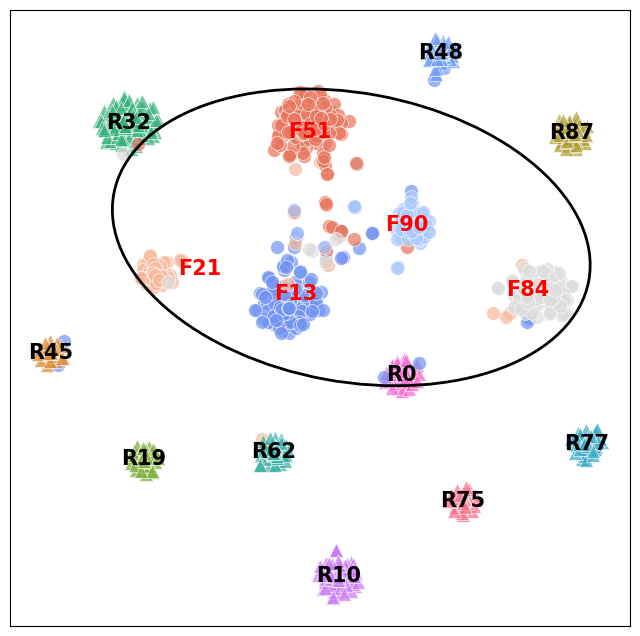

Selected f_labels: [84 74 46 21 90]
Selected r_labels: [59 25 17 94 18 92 85 65 19 67]


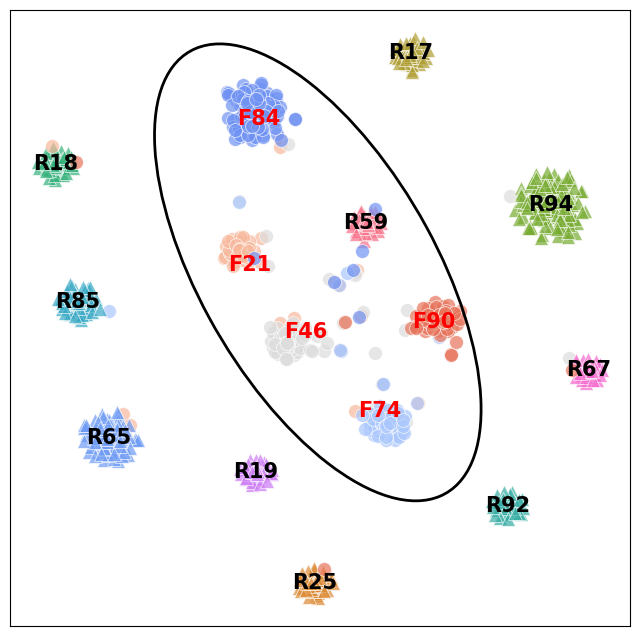

Selected f_labels: [81 39 54 93 51]
Selected r_labels: [ 9 22 12 14 86 15 58 99 48 60]


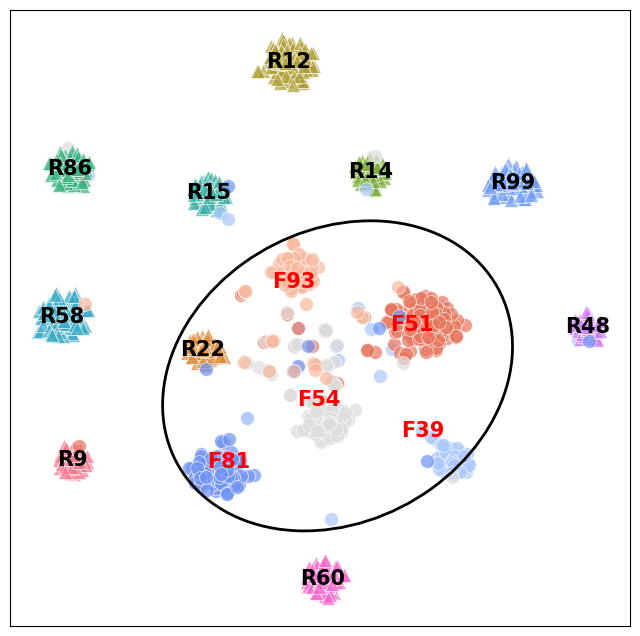

Selected f_labels: [46 21 74 54 73]
Selected r_labels: [70 15  4 43 65 14 64 69 97 80]


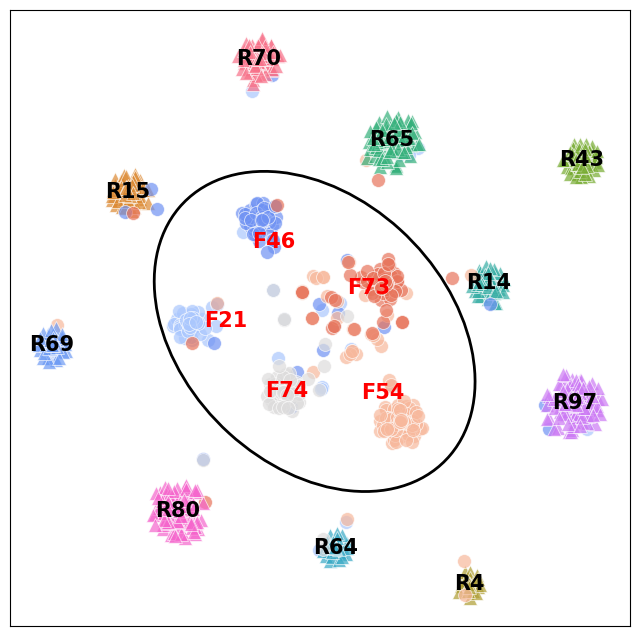

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import os


current_file_path = os.path.abspath("__file__")
current_folder = os.path.dirname(current_file_path)
parent_folder = os.path.dirname(current_folder)
os.chdir(parent_folder)



import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import random
import matplotlib.lines as mlines
from matplotlib.patches import Ellipse


seed = 42
np.random.seed(seed)
random.seed(seed)

# path_dir = './LOG/test/tsne/ours/tsne_npy'
# path_dir = './LOG/test/tsne/gslora/tsne_npy'
path_dir = './LOG/test/tsne/gt/tsne_npy_20250303'


features_f = np.load(path_dir + '/features_f.npy')
labels_f = np.load(path_dir + '/labels_f.npy')
features_r = np.load(path_dir + '/features_r.npy')
labels_r = np.load(path_dir + '/labels_r.npy')


unique_f_labels = np.unique(labels_f)


num_classes_to_select = 5
num_classes_to_select_remain = 10
iteration = 0
for _ in range(0, len(unique_f_labels), num_classes_to_select):
    iteration += 1
    selected_f_labels = np.random.choice(unique_f_labels, size=num_classes_to_select, replace=False)
    print("=================================")
    print('Selected f_labels:', selected_f_labels)
    print("=================================")

    f_indices = np.isin(labels_f, selected_f_labels)
    features_f_selected = features_f[f_indices]
    labels_f_selected = labels_f[f_indices]

    selected_r_labels = np.random.choice(np.unique(labels_r), size=num_classes_to_select_remain, replace=False)
    print('Selected r_labels:', selected_r_labels)

    features_r_selected = []
    for r_label in selected_r_labels:
        r_indices = np.where(labels_r == r_label)
        features_r_selected.append(features_r[r_indices])

    features_selected = np.concatenate([features_f_selected] + features_r_selected, axis=0)
    labels_selected = np.concatenate([labels_f_selected] +
                                     [np.full(features_r_selected[i].shape[0], selected_r_labels[i])
                                      for i in range(len(selected_r_labels))], axis=0)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    reduced_features = tsne.fit_transform(features_selected)


    plt.figure(figsize=(8, 8))


    colors_f = sns.color_palette("coolwarm", len(selected_f_labels))
    colors_r = sns.color_palette("husl", len(selected_r_labels))


    markers_f = ['o'] * num_classes_to_select
    markers_r = ['^'] * num_classes_to_select_remain

    color_dict = {}
    marker_dict = {}

    for i, label in enumerate(selected_f_labels):
        color_dict[label] = colors_f[i]
        marker_dict[label] = markers_f[i % len(markers_f)]

    for i, label in enumerate(selected_r_labels):
        color_dict[label] = colors_r[i]
        marker_dict[label] = markers_r[i % len(markers_r)]


    f_handles = []
    r_handles = []


    unique_labels = np.unique(labels_selected)
    for label in unique_labels:
        mask = (labels_selected == label)
        shape = marker_dict[label]
        

        if label in selected_f_labels:
            legend_label = f'F{label}'
            handles_list = f_handles  
        else:
            legend_label = f'R{label}'
            handles_list = r_handles  

        sns.scatterplot(x=reduced_features[mask, 0], y=reduced_features[mask, 1],
                        color=color_dict[label], s=100, alpha=0.7,
                        marker=shape, edgecolor='white', linewidth=0.6, label=legend_label)


        legend_handle = mlines.Line2D([], [], color=color_dict[label], marker=shape,
                                    markersize=10, linestyle='None', label=legend_label)
        handles_list.append(legend_handle)


        center_x = np.mean(reduced_features[mask, 0])
        center_y = np.mean(reduced_features[mask, 1])
        

        if label in selected_f_labels:
            class_label = f"F{label}"
            text_color = 'red'
        else:
            class_label = f"R{label}"
            text_color = 'black'

        plt.text(center_x, center_y, class_label, fontsize=15, ha='center', va='center', 
                fontweight='bold', color=text_color)


    forget_mask = np.isin(labels_selected, selected_f_labels)
    forget_points = reduced_features[forget_mask]

    if len(forget_points) > 2:
        center_x = np.mean(forget_points[:, 0])
        center_y = np.mean(forget_points[:, 1])
        cov = np.cov(forget_points.T)  
        eigenvalues, eigenvectors = np.linalg.eigh(cov)  

        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))  
        width, height = 2 * np.sqrt(eigenvalues) * 2  

        ellipse = Ellipse((center_x, center_y), width, height, angle=angle, 
                          edgecolor='black', facecolor='none', linewidth=2)
        plt.gca().add_patch(ellipse)

    legend1 = plt.legend(handles=f_handles, title="Forget", loc='upper left', ncol=1, bbox_to_anchor=(1.02, 1), borderaxespad=0., frameon=True)
    legend2 = plt.legend(handles=r_handles, title="Remain", loc='lower left', ncol=1, bbox_to_anchor=(1.02, 0), borderaxespad=0., frameon=True)


    for text in legend1.get_texts():
        text.set_fontsize(14)  

    for text in legend2.get_texts():
        text.set_fontsize(14)

    legend1._legend_title_box._text.set_fontsize(16)
    legend2._legend_title_box._text.set_fontsize(16)

    plt.gca().add_artist(legend1)

    plt.xticks([])
    plt.yticks([])
    plt.legend().remove()


    plt.savefig(path_dir + "seed_{}_{}_tsne_visualization1.pdf".format(seed, iteration), dpi=300, bbox_inches='tight', format='pdf')
    plt.show()

